In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('../artifacts/Amazon Smart Phones Product Reviews and Rating dataset.csv') 

# Display the first few rows
df.head()

,Unnamed: 0,product_id,product_url,product_name,product_img,product_price,product_overall_rating,total_reviews,user_name,review_url,review_rating,review_title,review_description
0,0,B0CMDMKQB7,https://www.amazon.com/SAMSUNG-Smartphone-Unlo...,"Samsung Galaxy S24 Ultra Cell Phone, 512GB AI ...",https://m.media-amazon.com/images/I/71WcjsOVOm...,"$1,169.99",4.5,"3,656",Carl,https://www.amazon.com/gp/customer-reviews/R3E...,5.0,Great phone with tons of features!,I've had the Samsung Galaxy s24 128gb marble g...
1,1,B0CMDMKQB7,https://www.amazon.com/SAMSUNG-Smartphone-Unlo...,"Samsung Galaxy S24 Ultra Cell Phone, 512GB AI ...",https://m.media-amazon.com/images/I/71WcjsOVOm...,"$1,169.99",4.5,"3,656",Adrian,https://www.amazon.com/gp/customer-reviews/R8W...,5.0,The perfect phone that doesn't come cheap,"PLEEEEEASE people, stop complaining about the ..."
2,2,B0CMDMKQB7,https://www.amazon.com/SAMSUNG-Smartphone-Unlo...,"Samsung Galaxy S24 Ultra Cell Phone, 512GB AI ...",https://m.media-amazon.com/images/I/71WcjsOVOm...,"$1,169.99",4.5,"3,656",Sharke,https://www.amazon.com/gp/customer-reviews/RRL...,5.0,"A Powerhouse with Stunning Display, Sleek Desi...",I've been using the Samsung Galaxy S24 Ultra f...
3,3,B0CMDMKQB7,https://www.amazon.com/SAMSUNG-Smartphone-Unlo...,"Samsung Galaxy S24 Ultra Cell Phone, 512GB AI ...",https://m.media-amazon.com/images/I/71WcjsOVOm...,"$1,169.99",4.5,"3,656",Cynthia,https://www.amazon.com/gp/customer-reviews/R3R...,5.0,Fast and Efficient,"This phone is blazing fast, I can't believe ho..."
4,4,B0CMDMKQB7,https://www.amazon.com/SAMSUNG-Smartphone-Unlo...,"Samsung Galaxy S24 Ultra Cell Phone, 512GB AI ...",https://m.media-amazon.com/images/I/71WcjsOVOm...,"$1,169.99",4.5,"3,656",Karl,https://www.amazon.com/gp/customer-reviews/RTH...,5.0,"Excellent camera, fast and responsive","Love my new phone, it's sharp clean and full ..."


In [3]:
# Count reviews per product
product_counts = df['product_name'].value_counts()
print(product_counts)

product_name
Samsung Galaxy A15 A155M 128GB Dual-SIM GSM Unlocked Android Smartphone (Latin America Version) - Blue Black                                                                                               1755
Samsung Galaxy A05 A055M 64GB Dual-SIM GSM Unlocked Android Smartphone (Latin America Version) - Light Green                                                                                               1755
Samsung Galaxy A15 (SM-155M/DSN), 128GB 6GB RAM, Dual SIM, Factory Unlocked GSM, International Version (Wall Charger Bundle) (Light Blue)                                                                  1755
SAMSUNG,Galaxy A04e (SM-A042M/DS) Dual SIM 32GB,6.5'' GSM Unlocked,International Version-Black                                                                                                             1755
SAMSUNG Galaxy A05 (128GB, 4GB) 6.7" Dual SIM Fully Unlocked Global 4G LTE A055M/DS (Black)                                                                

In [4]:
# Find null values
print("Null values per column:")
print(df.isnull().sum())

# Total null values
print(f"\nTotal null values: {df.isnull().sum().sum()}")

# Percentage of null values
print("\nPercentage of null values per column:")
print((df.isnull().sum() / len(df)) * 100)

Null values per column:
Unnamed: 0                    0
product_id                    0
product_url                   0
product_name                  0
product_img                   0
product_price             12015
product_overall_rating        0
total_reviews                 0
user_name                     0
review_url                 8505
review_rating                 0
review_title                  0
review_description            0
dtype: int64

Total null values: 20520

Percentage of null values per column:
Unnamed: 0                 0.000000
product_id                 0.000000
product_url                0.000000
product_name               0.000000
product_img                0.000000
product_price             43.842365
product_overall_rating     0.000000
total_reviews              0.000000
user_name                  0.000000
review_url                31.034483
review_rating              0.000000
review_title               0.000000
review_description         0.000000
dtype: float64

In [5]:
df["review_text"] = df["review_title"] + ". " + df["review_description"]


In [6]:
df = df.drop(columns=['review_title', 'review_description'])

In [7]:
df = df.drop(columns=['total_reviews'])

In [8]:
df.shape

(27405, 11)

In [9]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_text"] = df["review_text"].apply(clean_text)


In [10]:
df = df.drop(columns=['Unnamed: 0'])

In [11]:
df = df.drop(columns=['review_text'])

In [12]:
df.shape

(27405, 10)

In [13]:
# Remove duplicate rows based on clean_text column
df = df.drop_duplicates(subset=['clean_text'], keep='first')
print(f"Shape after removing duplicates: {df.shape}")

Shape after removing duplicates: (203, 10)


In [14]:
# Install required libraries (run in terminal first)
# pip install transformers torch sentencepiece

from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load pre-trained BERT sentiment model
sentiment_pipeline = pipeline("sentiment-analysis", 
                             model="nlptown/bert-base-multilingual-uncased-sentiment")

# Define the smartphone features you want to track
aspect_map = {
    "battery": ["battery", "charging", "power", "mah", "runtime"],
    "camera": ["camera", "photos", "lens", "zoom", "video", "selfie"],
    "display": ["screen", "display", "resolution", "refresh rate", "oled", "amoled"],
    "performance": ["speed", "gaming", "ram", "processor", "chipset", "lag"],
    "storage": ["storage", "memory", "gb", "space"],
    "design": ["design", "build", "looks", "premium", "lightweight"],
    "price": ["price", "value", "worth", "expensive", "cheap"],
    "sound": ["sound", "speaker", "audio", "volume", "music"]
}

# Function to extract sentences mentioning aspects
def extract_aspect_sentences(text, aspect_keywords):
    sentences = text.split('.')
    aspect_sentences = []
    for sent in sentences:
        sent = sent.strip()
        if len(sent) > 0 and any(keyword in sent.lower() for keyword in aspect_keywords):
            aspect_sentences.append(sent)
    return aspect_sentences

# Function to analyze sentiment with BERT for each aspect
def bert_aspect_sentiment(text):
    aspect_sentiments = {}
    
    for aspect, keywords in aspect_map.items():
        aspect_sents = extract_aspect_sentences(text, keywords)
        
        if aspect_sents:
            sentiments = []
            for sent in aspect_sents[:3]:  # Limit to 3 sentences per aspect
                try:
                    if len(sent) > 10:  # Minimum length check
                        result = sentiment_pipeline(sent[:512])[0]  # BERT max length
                        # Convert star rating to score (-1 to 1)
                        label = result['label']
                        score = int(label.split()[0]) - 3  # Convert 1-5 stars to -2 to 2
                        score = score / 2  # Normalize to -1 to 1
                        sentiments.append(score)
                except:
                    continue
            
            if sentiments:
                aspect_sentiments[aspect] = {
                    'score': np.mean(sentiments),
                    'count': len(sentiments),
                    'sentiment': 'positive' if np.mean(sentiments) > 0.1 else ('negative' if np.mean(sentiments) < -0.1 else 'neutral')
                }
    
    return aspect_sentiments

# Apply to dataset (test on first 100 rows)
print("Processing sentiment analysis...")
df['aspect_sentiments'] = df['clean_text'].head(100).apply(bert_aspect_sentiment)

# Display sample results
print("\nSample results:")
print(df[['product_name', 'aspect_sentiments']].head())

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Processing sentiment analysis...

Sample results:
                                        product_name  \
0  Samsung Galaxy S24 Ultra Cell Phone, 512GB AI ...   
1  Samsung Galaxy S24 Ultra Cell Phone, 512GB AI ...   
2  Samsung Galaxy S24 Ultra Cell Phone, 512GB AI ...   
3  Samsung Galaxy S24 Ultra Cell Phone, 512GB AI ...   
4  Samsung Galaxy S24 Ultra Cell Phone, 512GB AI ...   

                                   aspect_sentiments  
0  {'battery': {'score': 0.5, 'count': 1, 'sentim...  
1  {'battery': {'score': 0.25, 'count': 2, 'senti...  
2  {'battery': {'score': 1.0, 'count': 2, 'sentim...  
3  {'design': {'score': 1.0, 'count': 1, 'sentime...  
4  {'camera': {'score': 1.0, 'count': 1, 'sentime...  


In [16]:
# Extract aspect scores into separate columns
def extract_aspect_scores(row):
    scores = {}
    # Check if row is a dictionary (not NaN or other types)
    if not isinstance(row, dict):
        for aspect in aspect_map.keys():
            scores[f'{aspect}_score'] = None
    else:
        for aspect in aspect_map.keys():
            if aspect in row:
                scores[f'{aspect}_score'] = row[aspect]['score']
            else:
                scores[f'{aspect}_score'] = None
    return pd.Series(scores)

# Apply extraction
aspect_scores_df = df['aspect_sentiments'].apply(extract_aspect_scores)
df = pd.concat([df, aspect_scores_df], axis=1)

# Aggregate by product
product_aspect_sentiments = df.groupby('product_name')[
    [col for col in df.columns if '_score' in col]
].mean()

print(product_aspect_sentiments)

                                                    battery_score  \
product_name                                                        
Google - Pixel 3a XL with 64GB Memory Cell Phon...            NaN   
Google Pixel 7a - Unlocked Android Cell Phone -...            NaN   
Moto G Play | 2024 | Unlocked | Made for US 4/6...       0.388889   
Moto G Power 5G | 2024 | Unlocked | Made for US...       0.527778   
Moto G Stylus 5G | 2024 | Unlocked | Made for U...       0.458333   
Moto G Stylus 5G | 2024 | Unlocked | Made for U...            NaN   
Motorola Moto G Power 5G | 2023 | Unlocked | Ma...       0.266667   
Motorola Moto G Stylus 5G | 2023 | Unlocked | M...            NaN   
Motorola razr | 2023 | Unlocked | Made for US 8...            NaN   
OnePlus Nord N30 5G | Unlocked Dual-SIM Android...       0.458333   
SAMSUNG Galaxy A05 (128GB, 4GB) 6.7" Dual SIM F...            NaN   
SAMSUNG Galaxy A15 5G A Series Cell Phone, 128G...            NaN   
SAMSUNG Galaxy A25 5G A Series Cel

In [ ]:
# Save processed data
df.to_csv('../artifacts/preprocessed_with_sentiments.csv', index=False)
print("Data saved successfully!")

Data saved successfully!


In [19]:
# Load and validate the saved file
df_check = pd.read_csv('../artifacts/preprocessed_with_sentiments.csv')
print(f"Shape: {df_check.shape}")
print(f"Columns: {df_check.columns.tolist()}")
print(df_check.head())

Shape: (203, 19)
Columns: ['product_id', 'product_url', 'product_name', 'product_img', 'product_price', 'product_overall_rating', 'user_name', 'review_url', 'review_rating', 'clean_text', 'aspect_sentiments', 'battery_score', 'camera_score', 'display_score', 'performance_score', 'storage_score', 'design_score', 'price_score', 'sound_score']
   product_id                                        product_url  \
0  B0CMDMKQB7  https://www.amazon.com/SAMSUNG-Smartphone-Unlo...   
1  B0CMDMKQB7  https://www.amazon.com/SAMSUNG-Smartphone-Unlo...   
2  B0CMDMKQB7  https://www.amazon.com/SAMSUNG-Smartphone-Unlo...   
3  B0CMDMKQB7  https://www.amazon.com/SAMSUNG-Smartphone-Unlo...   
4  B0CMDMKQB7  https://www.amazon.com/SAMSUNG-Smartphone-Unlo...   

                                        product_name  \
0  Samsung Galaxy S24 Ultra Cell Phone, 512GB AI ...   
1  Samsung Galaxy S24 Ultra Cell Phone, 512GB AI ...   
2  Samsung Galaxy S24 Ultra Cell Phone, 512GB AI ...   
3  Samsung Galaxy S24 Ul

In [20]:
# Remove .head(100) to process all rows
df['aspect_sentiments'] = df['clean_text'].apply(bert_aspect_sentiment)

In [21]:
from tqdm import tqdm
tqdm.pandas()
df['aspect_sentiments'] = df['clean_text'].progress_apply(bert_aspect_sentiment)

100%|██████████| 203/203 [03:51<00:00,  1.14s/it]


C:\Users\dell\AppData\Local\Temp\ipykernel_21520\2719636059.py:6: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


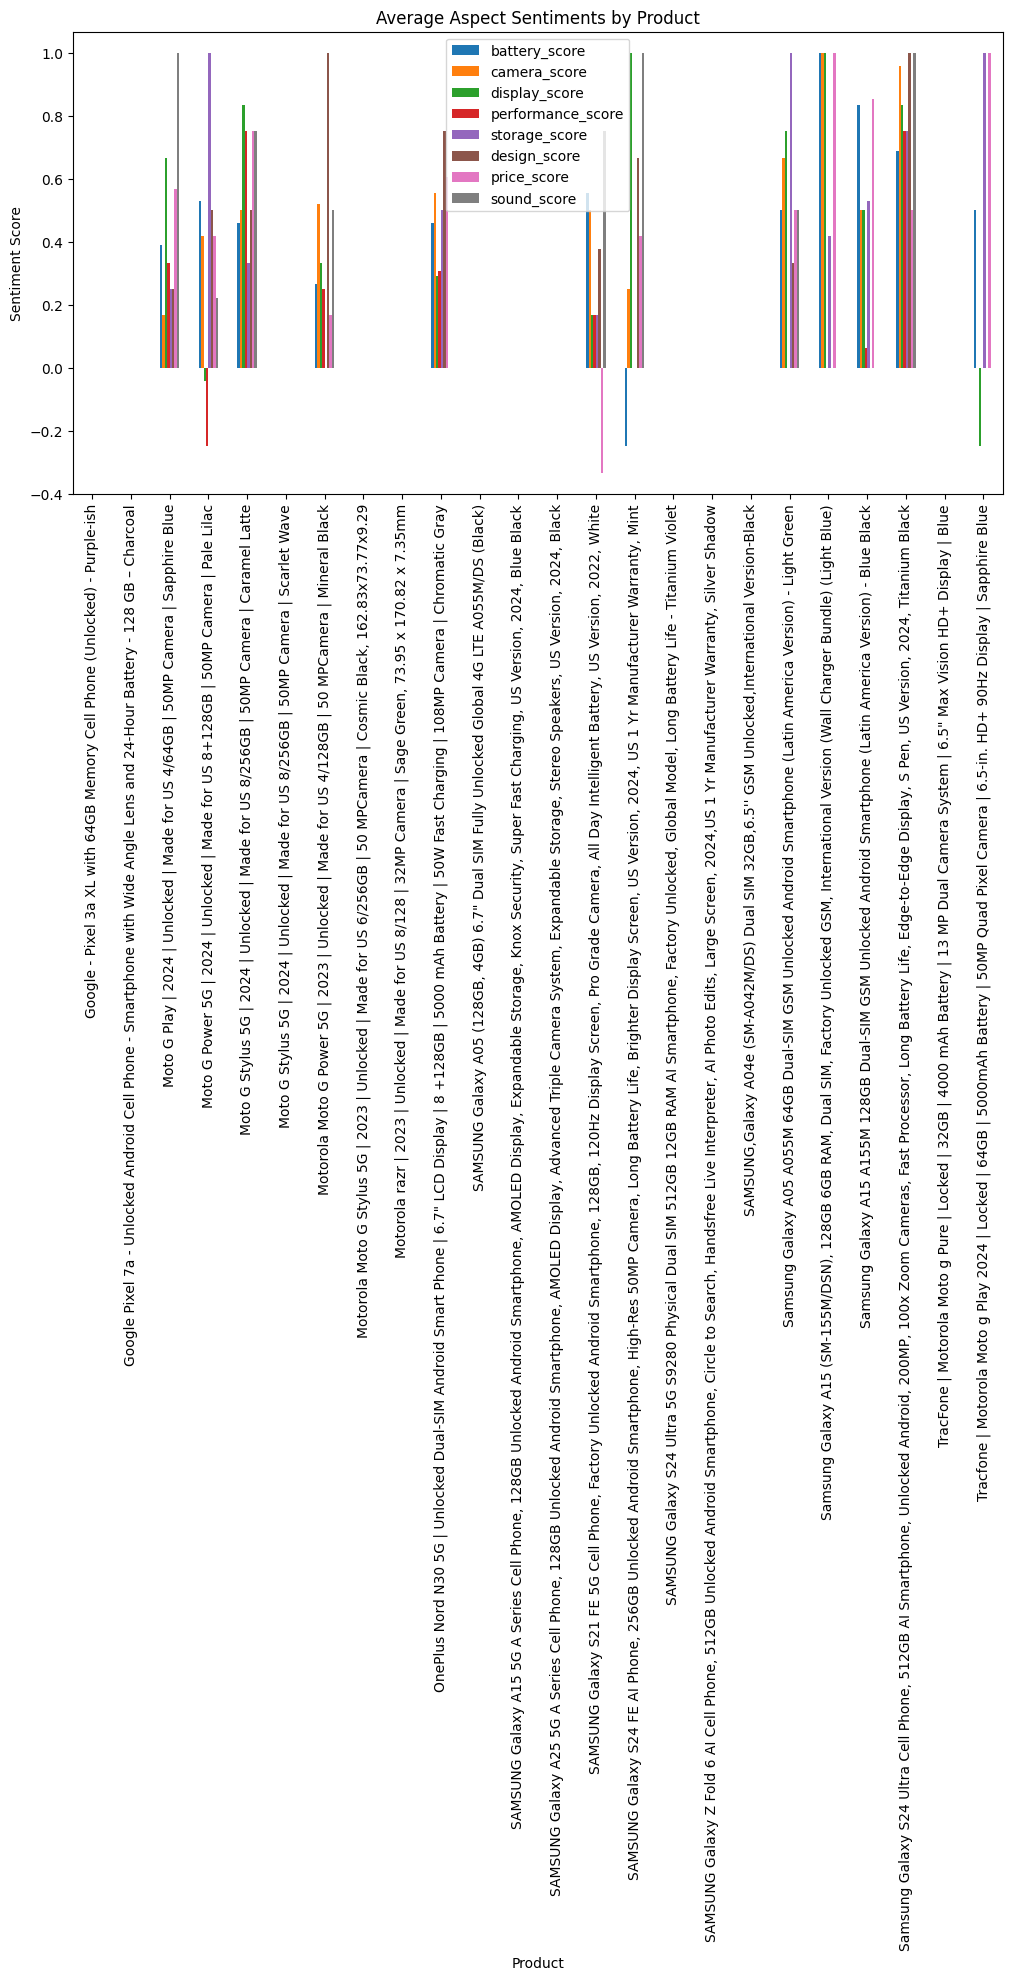

In [22]:
# Plot average sentiment scores by aspect
product_aspect_sentiments.plot(kind='bar', figsize=(12, 6))
plt.title('Average Aspect Sentiments by Product')
plt.xlabel('Product')
plt.ylabel('Sentiment Score')
plt.tight_layout()
plt.show()